# MNIST Digit Classification with Feed Forward Neural Network

## Import required Libraries

In [69]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Load Dataset

In [70]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

## Checking image in dataset

image.shape: torch.Size([1, 28, 28])
Label: 2


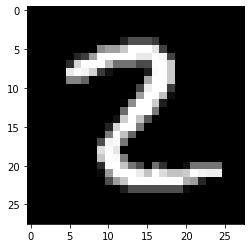

In [71]:
image, label = dataset[76]
print('image.shape:', image.shape)
plt.imshow(image[0],cmap='gray')
print('Label:', label)

## Splitting dataset into train an val

In [72]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [73]:
batch_size=128

## Creating train_loader and val_loader

In [74]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Look at multiple images from dataset using grid

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


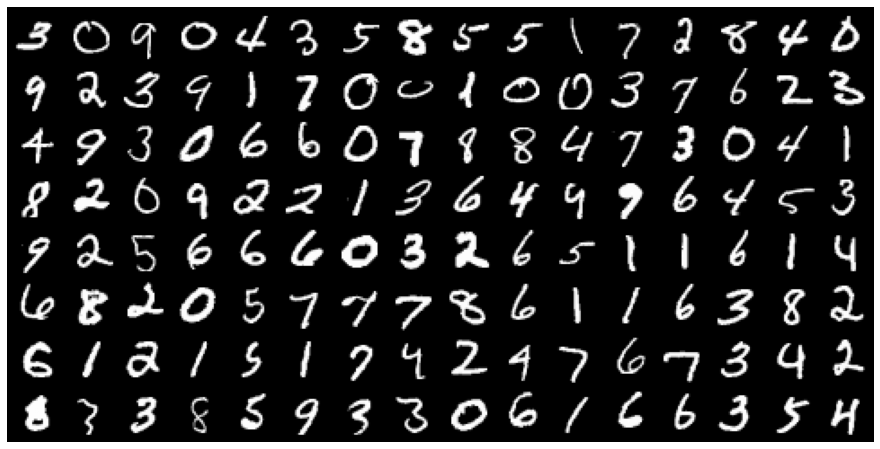

In [75]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

##Model

In [76]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [77]:
input_size = inputs.shape[-1]
hidden_size = 32
num_classes = len(dataset.classes)

## Model

### Accuracy Calculation Function

In [78]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [79]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## Using a GPU

In [80]:
torch.cuda.is_available()

True

In [81]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [82]:
device = get_default_device()
device

device(type='cuda')

In [83]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [84]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [85]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

##Utilities function

In [86]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Creating model

In [87]:
model = MnistModel(input_size, hidden_size=hidden_size,out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [88]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.10400390625, 'val_loss': 2.3172194957733154}]

## Training Model

In [89]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.2290, val_acc: 0.9363
Epoch [1], val_loss: 0.2036, val_acc: 0.9383
Epoch [2], val_loss: 0.1567, val_acc: 0.9518
Epoch [3], val_loss: 0.1476, val_acc: 0.9544
Epoch [4], val_loss: 0.1541, val_acc: 0.9523


In [90]:
history += fit(5, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.1241, val_acc: 0.9621
Epoch [1], val_loss: 0.1231, val_acc: 0.9627
Epoch [2], val_loss: 0.1225, val_acc: 0.9627
Epoch [3], val_loss: 0.1224, val_acc: 0.9633
Epoch [4], val_loss: 0.1220, val_acc: 0.9629


In [91]:
history += fit(5, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 0.1217, val_acc: 0.9634
Epoch [1], val_loss: 0.1217, val_acc: 0.9638
Epoch [2], val_loss: 0.1214, val_acc: 0.9641
Epoch [3], val_loss: 0.1211, val_acc: 0.9637
Epoch [4], val_loss: 0.1210, val_acc: 0.9642


## Model Evaluation

In [92]:
def eval_plot(history):
  accuracies = [x['val_acc'] for x in history]
  losses = [x2['val_loss'] for x2 in history]
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');
  plt.subplot(1, 2, 2)
  plt.plot(losses, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs. No. of epochs');

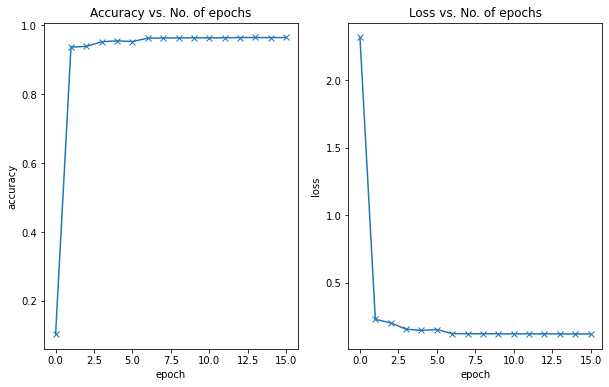

In [93]:
eval_plot(history)

##Prediction on test image

In [94]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 9 - nine , Predicted: 9 - nine


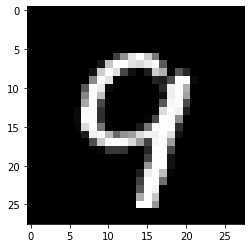

In [95]:
img, label = test_dataset[16]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

### Model score on test dataset

In [96]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.96728515625, 'val_loss': 0.10743949562311172}

## Save and Loading Model

In [97]:
saved_weights_fname='mnist-feedforward.pth'

In [98]:
torch.save(model.state_dict(), saved_weights_fname)

In [99]:
model2 = to_device(MnistModel(input_size, hidden_size=hidden_size,out_size=num_classes), device)

In [100]:
model2.load_state_dict(torch.load(saved_weights_fname))

<All keys matched successfully>